# Introduction

In this kernel we will explore the interconnectedness of addresses on the Ethereum Classic blockchain when viewed as a directed graph where each vertex represents an address and edges connect addresses that have transacted. To achieve this, we will leverage the module [graph-tool](https://graph-tool.skewed.de/), chosen for its performant C++ implementation and ability to visualize large graphs.


In [1]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client()
query = """
SELECT from_address, 
    to_address
FROM `bigquery-public-data.crypto_ethereum_classic.transactions` 
GROUP BY from_address, to_address
ORDER BY from_address ASC   
    
"""
df = client.query(query).to_dataframe()
df.describe()

Using Kaggle's public dataset BigQuery integration.


,from_address,to_address
count,5252244,5229992
unique,2152900,2458691
top,0xe592b0d8baa2cb677034389b76a71b0d1823e0d1,0x8837234b8d27cf4abdae353264f45c8866631ed5
freq,131711,186200


We can see that there is a discrepancy between the to and from address columns, implying that there are `None` values present in the data. Without prior knowledge explaining the presence of these, the only choice is to drop them from the dataframe

In [2]:
df = df.dropna()
df.describe()

,from_address,to_address
count,5229992,5229992
unique,2139201,2458691
top,0xe592b0d8baa2cb677034389b76a71b0d1823e0d1,0x8837234b8d27cf4abdae353264f45c8866631ed5
freq,131711,186200


Here is where we install graph-tool

In [3]:
!conda install --yes --override-channels -c ostrokach-forge -c pkgw-forge -c conda-forge gtk3 pygobject graph-tool

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pkginfo==1.4.2=py36_1
  - defaults/linux-64::anaconda-client==1.6.14=py36_0
  - defaults/linux-64::jupyterlab_launcher==0.10.5=py36_0
  - defaults/linux-64::pyparsing==2.2.0=py36hee85983_1
  - defaults/linux-64::jpeg==9b=h024ee3a_2
  - defaults/linux-64::xlsxwriter==1.0.4=py36_0
  - defaults/linux-64::sphinxcontrib==1.0=py36h6d0f590_1
  - defaults/linux-64::sympy==1.1.1=py36hc6d1c1c_0
  - defaults/linux-64::tblib==1.3.2=py36h34cf8b6_0
  - defaults/linux-64::unicodecsv==0.14.1=py36ha668878_0
  - defaults/linux-64::idna==2.6=py36h82fb2a8_1
  - defaults/linux-64::terminado==0.8.1=py36_1
  - defaults/linux-64::jupyter_client==5.2.3=py36_0
  - defaults/linux-64::py==1.5.3=py36_0
  - defaults/linux-64::nltk==3.3.0=py36_0
  - defaults/linux-64::s

Next, we'll create the directed graph object.

In [4]:
import graph_tool.all as gt

g = gt.Graph(directed=True)

# populate the graph with vertices and store their references in a dict that
# uniquely maps each address to a vertex
vertex_map = set(pd.concat([df['from_address'], df['to_address']], axis=0))
new_vertices = g.add_vertex(len(vertex_map))
vertex_map = dict(zip(vertex_map, new_vertices))

#add edges
def edge_map(e):
    return (vertex_map[e[0]], vertex_map[e[1]])
edge_list = map(edge_map, df[['from_address', 'to_address']].itertuples(index=False, name=None))
g.add_edge_list(edge_list)

First we'll investigate whether the graph is connected (ignoring directionality) and if not, the number of components.

In [5]:
comp, hist = gt.label_components(g, directed=False) #outputs a histogram of the # of vertices belonging to each component
print("The graph has", len(hist), "components")
print("the largest component has", max(hist), "vertices, %{:.2f} of the total.".format(100*max(hist)/len(g.get_vertices())))
print("the 2nd and 3rd largest components have {:d} and {:d} vertices respectively".format(sorted(hist, reverse=True)[1], sorted(hist, reverse=True)[2]))

The graph has 3515 components
the largest component has 2489339 vertices, %98.77 of the total.
the 2nd and 3rd largest components have 6602 and 5607 vertices respectively


# Average smallest path length

Since the graph is so large, it is computationally prohibitive to determine the average smallest path length by exhaustively finding the smallest path between each pair of vertices. Instead, we will take a Monte-Carlo approach to approximate the average smallest path length by selecting a random subset of vertex pairs. We'll only look in the largest connected component since it accounts for %98.77 of the vertices in the graph and we want to make sure a path exists between each vertex pair.

Here we will view the graph as undirected and therefore consider each transaction as a relationship between vertices, regardless of direction.


In [6]:
import random
from tqdm import tqdm
from multiprocessing import Pool

sample_size = 10000

#get those vertices that belong to the largest component
comp = gt.label_largest_component(g, directed=False)
vertices_subset = [i for i, x in enumerate(comp) if x]

#randomly select vertex pairs
source_samples = random.choices(vertices_subset, k=sample_size)
target_samples = random.choices(vertices_subset, k=sample_size)
sample_pairs = zip(source_samples, target_samples)

def get_shortest_distance(pair):
    return gt.shortest_distance(g, pair[0], pair[1], directed=False)
pool = Pool(4)
distance_list = list(tqdm(pool.imap(get_shortest_distance, sample_pairs), total=sample_size))
pool.close()
pool.join()

100%|██████████| 10000/10000 [19:02<00:00,  5.56it/s]


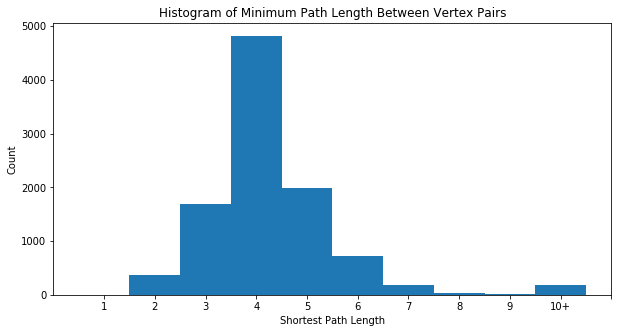

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
# plt.yscale("log")
# plt.xscale("log")
plt.title('Histogram of Minimum Path Length Between Vertex Pairs')
plt.xlabel('Shortest Path Length')
plt.ylabel('Count')

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
hist, _ = np.histogram(distance_list, bins)

plt.xticks(range(len(bins)), bins[:-2] + ['{}+'.format(bins[-2])])
plt.bar(range(len(hist)), hist, width=1)
plt.show()

# Clustering Coeficient

In [8]:
import datetime
start_time = datetime.datetime.now()

clustering = gt.global_clustering(g)
print("computation time:", datetime.datetime.now() - start_time)
print('The clustering coeficient of the transaction network is:', clustering[0])

computation time: 0:14:58.968928
The clustering coeficient of the transaction network is: 0.00017473434845558398


# Degree Histogram
Generate a histogram of the vertex degrees present in the network.

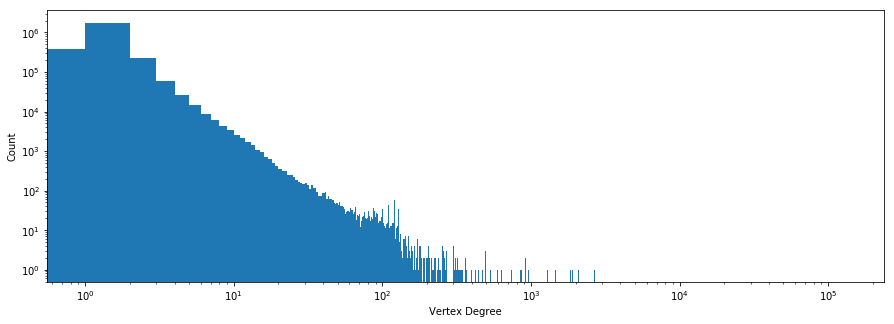

In [9]:
import matplotlib.pyplot as plt

degrees = g.get_out_degrees(g.get_vertices())
plt.figure(figsize=(15,5))
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Vertex Degree')
plt.ylabel('Count')

plt.hist(degrees, max(degrees))

plt.show()

# Graph Visualization
Since the graph is so large, it is wise to reduce the number of vertices that are to be drawn both to improve the readability of the visualization and to bring the down the computation time. 

We will generate a condensed version of the graph by taking all vertices belonging to the same [strongly connected component](https://en.wikipedia.org/wiki/Strongly_connected_component) and replacing them with a single vertex. When done for each strongly connected component, the result is a graph that represents connections between communities of addresses as well as individual addresses.

In [10]:
comp, hist = gt.label_components(g, directed=True) # label strongly connected components
condensed_g, _, vcount, _, _, _ = gt.condensation_graph(g, comp) # generate a new graph from component labels

print("# of vertices in the original graph:", len(g.get_vertices()))
print("# of strongly connected components in the original graph:", len(hist))
print("# of vertices in the condensed graph:", len(condensed_g.get_vertices()))

# of vertices in the original graph: 2520260
# of strongly connected components in the original graph: 989186
# of vertices in the condensed graph: 989186


In the next cell, we will generate a visualization of the condensed graph using the [SFDP layout algorithm](https://www.mathematica-journal.com/issue/v10i1/graph_draw.html) which has $ O(V\log V) $ time complexity with $V$ being the number of vertices.

**The next cell takes a very long time to execute**

Coarse level (MIVS): 2  num vertices: 862342
Coarse level (MIVS): 3  num vertices: 118887
Coarse level (MIVS): 4  num vertices: 94304
Coarse level (MIVS): 5  num vertices: 17162
Coarse level (MIVS): 6  num vertices: 12881
Coarse level (MIVS): 7  num vertices: 5677
Coarse level (MIVS): 8  num vertices: 4228
Positioning level: 0 4228 with K = 33.77517561448382 ...
avg edge distance: 103.11398132663022
propagating... 4228
Positioning level: 1 5677 with K = 25.331381710862864 ...
avg edge distance: 75.26103522103506
propagating... 5676
Positioning level: 2 12881 with K = 18.998536283147146 ...
avg edge distance: 77.03238377999664
propagating... 12881
Positioning level: 3 17162 with K = 14.24890221236036 ...
avg edge distance: 54.66895945876404
propagating... 17161
Positioning level: 4 94304 with K = 10.686676659270269 ...
avg edge distance: 63.54821909169096
propagating... 94303
Positioning level: 5 118887 with K = 8.015007494452702 ...
avg edge distance: 40.31175859442948
propagating... 1

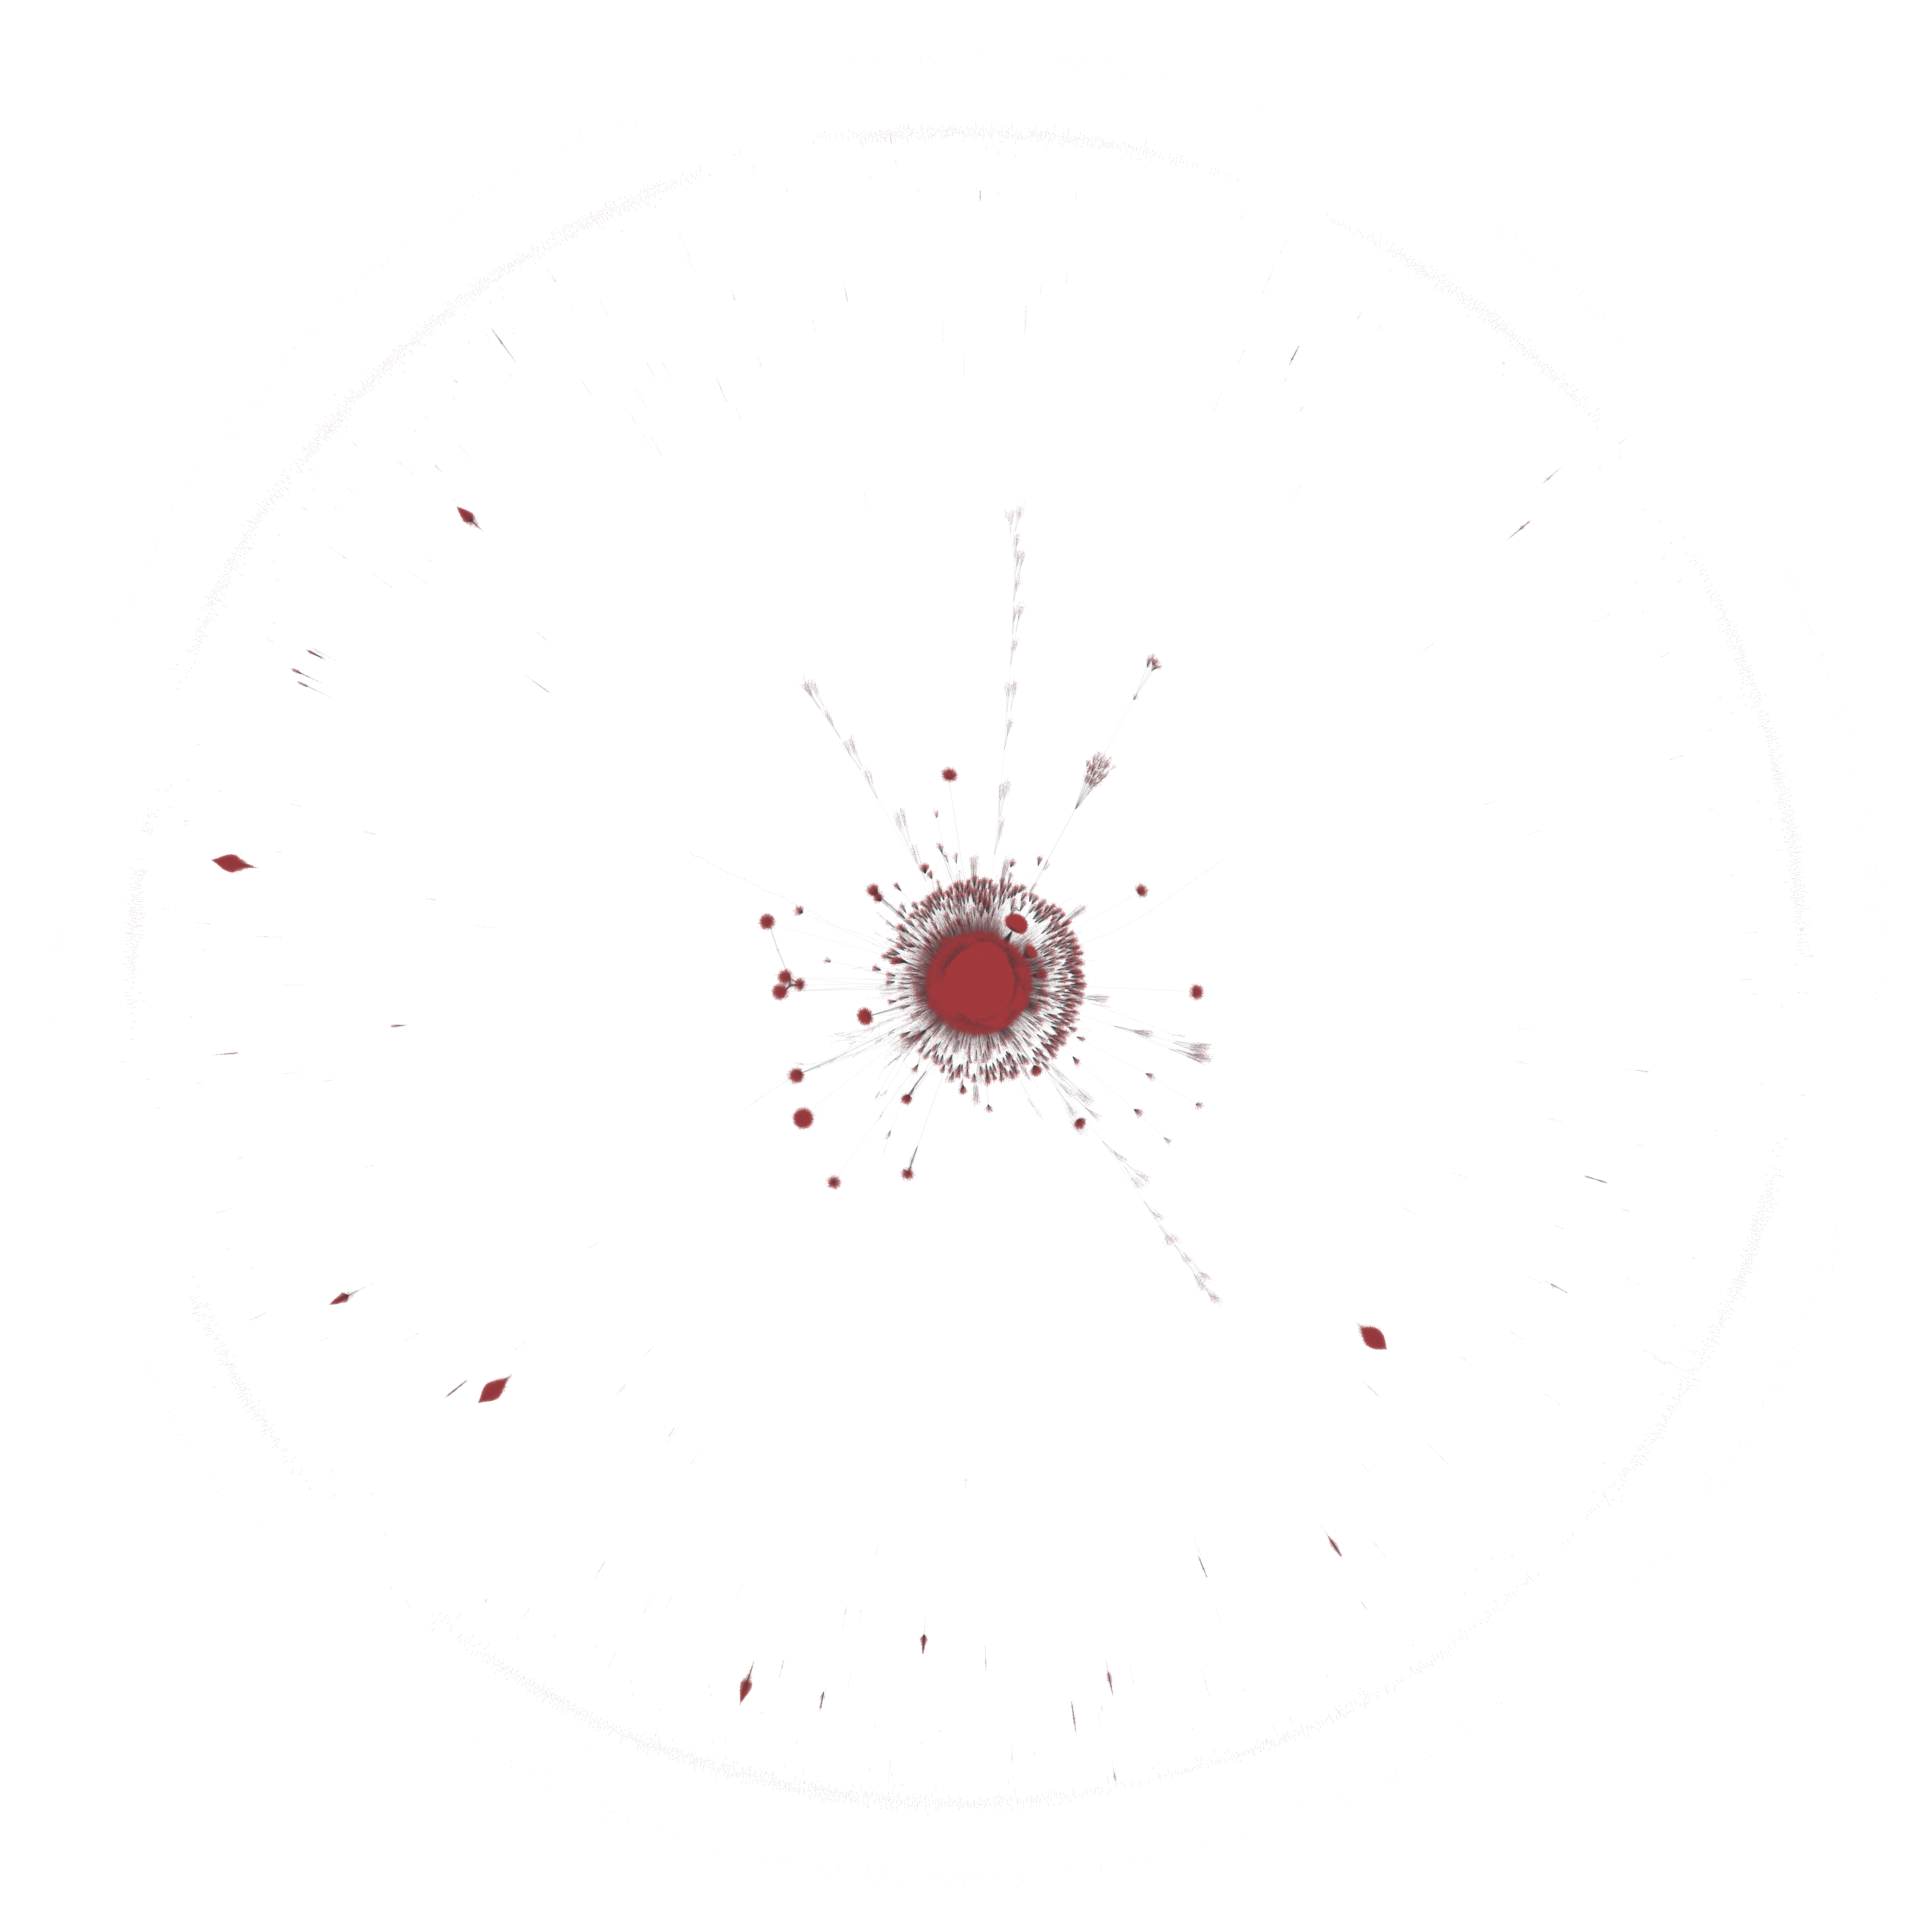

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f0e3ff91048, at 0x7f0e441d9898>

In [11]:
import datetime

start_time = datetime.datetime.now()
pos = gt.sfdp_layout(condensed_g, epsilon=2.0, pos=None, verbose=True)
print("computation time:", datetime.datetime.now() - start_time)
gt.graph_draw(condensed_g, pos=pos, output_size=(5000, 5000),vertex_size=1.0,  edge_pen_width=0.1)